In [36]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import mannwhitneyu, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [37]:
data_dir = "./data"
output_dir = "./output/Phase_4"
os.makedirs(output_dir, exist_ok=True)

In [38]:
BRAIN_SIGNATURES = {
    'Neurons_Pan': ['SNAP25', 'SYT1', 'RBFOX3', 'MAP2', 'ENO2', 'SYN1', 'SYP', 'NRGN', 'NEFL'],
    'Neurons_Excit': ['SLC17A7', 'SLC17A6', 'GRIN1', 'GRIN2A', 'GRIN2B', 'CAMK2A'],
    'Neurons_Inhib': ['GAD1', 'GAD2', 'SLC32A1', 'PVALB', 'SST', 'VIP', 'NPY'],
    'Astrocytes': ['GFAP', 'AQP4', 'ALDH1L1', 'SLC1A2', 'SLC1A3', 'S100B', 'GLUL'],
    'Microglia': ['AIF1', 'CD68', 'ITGAM', 'CX3CR1', 'P2RY12', 'TMEM119', 'TREM2'],
    'Oligodendro': ['MBP', 'MOG', 'PLP1', 'MAG', 'CNP', 'OLIG1', 'OLIG2'],
    'Endothelial': ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']
}

In [39]:
def load_data(expr_path, meta_path):
    """Load expression and metadata"""
    expr = pd.read_csv(expr_path, index_col=0)
    meta = pd.read_csv(meta_path, index_col=0)
    print(f"Loaded: {expr.shape[1]} samples, {expr.shape[0]} genes")
    print(f"Groups: {meta['Status'].value_counts().to_dict()}")
    return expr, meta

In [40]:
def ssgsea_score(expr_df, gene_set, gene_set_name=""):
    """
    Single-sample GSEA scoring (simplified enrichment score)
    Returns a score for each sample based on the gene set
    """
    # Find overlapping genes
    available_genes = [g for g in gene_set if g in expr_df.index]
    coverage = len(available_genes) / len(gene_set)
    
    if len(available_genes) < 3:
        print(f"  Warning: {gene_set_name} has only {len(available_genes)} genes available")
        return pd.Series(np.nan, index=expr_df.columns)
    
    print(f"  {gene_set_name}: {len(available_genes)}/{len(gene_set)} markers found ({coverage:.1%})")
    
    # Z-score normalize expression
    expr_subset = expr_df.loc[available_genes]
    expr_z = (expr_subset - expr_subset.mean(axis=1).values.reshape(-1,1)) / expr_subset.std(axis=1).values.reshape(-1,1)
    
    # Score = mean z-score across marker genes
    scores = expr_z.mean(axis=0)
    
    return scores

In [41]:
def run_deconvolution(expr_df, signatures=BRAIN_SIGNATURES):
    """Run cell-type scoring for all brain cell types"""
    print("\n" + "="*50)
    print("RUNNING BRAIN CELL-TYPE DECONVOLUTION")
    print("="*50)
    
    results = pd.DataFrame(index=expr_df.columns)
    
    for cell_type, markers in signatures.items():
        scores = ssgsea_score(expr_df, markers, cell_type)
        results[cell_type] = scores
    
    # Standardize scores for comparability
    scaler = StandardScaler()
    results_scaled = pd.DataFrame(
        scaler.fit_transform(results),
        index=results.index,
        columns=results.columns
    )
    
    return results_scaled

In [42]:
def statistical_validation(deconv_results, metadata):
    """Compare cell-type scores between MDD and Control"""
    print("\n" + "="*50)
    print("STATISTICAL VALIDATION: MDD vs CONTROL")
    print("="*50)
    
    # Merge deconvolution results with metadata
    # Handle different index formats
    if 'Sample_Title' in metadata.columns:
        merged = deconv_results.join(metadata.set_index(metadata.index)['Status'])
    else:
        merged = deconv_results.copy()
        merged['Status'] = metadata['Status'].values
    
    results_table = []
    
    for cell_type in deconv_results.columns:
        mdd_scores = merged[merged['Status'] == 'MDD'][cell_type].dropna()
        ctrl_scores = merged[merged['Status'] == 'Control'][cell_type].dropna()
        
        # Mann-Whitney U test
        stat, p_value = mannwhitneyu(mdd_scores, ctrl_scores, alternative='two-sided')
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt((mdd_scores.std()**2 + ctrl_scores.std()**2) / 2)
        cohens_d = (mdd_scores.mean() - ctrl_scores.mean()) / pooled_std if pooled_std > 0 else 0
        
        results_table.append({
            'Cell_Type': cell_type,
            'MDD_Mean': mdd_scores.mean(),
            'Control_Mean': ctrl_scores.mean(),
            'Cohens_d': cohens_d,
            'P_Value': p_value,
            'Direction': 'MDD > Ctrl' if cohens_d > 0 else 'MDD < Ctrl'
        })
        
        # Print result
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"  {cell_type:20s}: Cohen's d = {cohens_d:+.3f}, p = {p_value:.4f} {sig}")
    
    results_df = pd.DataFrame(results_table)
    results_df['P_Adjusted'] = stats.false_discovery_control(results_df['P_Value'], method='bh')
    
    return results_df, merged


In [43]:
def plot_validation_results(merged_data, stats_results, output_dir):
    """Create publication-quality validation plots"""
    
    cell_types = [c for c in merged_data.columns if c != 'Status']
    
    # Figure 1: Boxplots for all cell types
    fig, axes = plt.subplots(2, 4, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, cell_type in enumerate(cell_types):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Get stats for this cell type
        row = stats_results[stats_results['Cell_Type'] == cell_type].iloc[0]
        p_val = row['P_Value']
        d = row['Cohens_d']
        
        # Color based on significance
        palette = ['#3498db', '#e74c3c']  # Blue for Control, Red for MDD
        
        sns.boxplot(data=merged_data, x='Status', y=cell_type, ax=ax, 
                   palette=palette, order=['Control', 'MDD'])
        sns.stripplot(data=merged_data, x='Status', y=cell_type, ax=ax,
                     color='black', alpha=0.3, size=3, order=['Control', 'MDD'])
        
        # Significance annotation
        sig_text = f"d={d:.2f}\np={p_val:.3f}"
        if p_val < 0.05:
            sig_text += " *"
        ax.set_title(f"{cell_type}\n{sig_text}", fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Score (z-normalized)')
    
    # Hide empty subplots
    for idx in range(len(cell_types), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('GSE98793 Validation: Brain Cell-Type Scores by Diagnosis', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/GSE98793_validation_boxplots.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{output_dir}/GSE98793_validation_boxplots.pdf", bbox_inches='tight')
    print(f"\nSaved: {output_dir}/GSE98793_validation_boxplots.png")
    
    # Figure 2: Effect size summary
    fig, ax = plt.subplots(figsize=(10, 6))
    
    stats_sorted = stats_results.sort_values('Cohens_d')
    colors = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in stats_sorted['P_Value']]
    
    bars = ax.barh(stats_sorted['Cell_Type'], stats_sorted['Cohens_d'], color=colors)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=-0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel("Cohen's d (Effect Size)", fontsize=12)
    ax.set_title("Effect Sizes: MDD vs Control\n(Red = p < 0.05, Dashed lines = |d| = 0.3)", fontsize=12)
    
    # Add p-value annotations
    for idx, (_, row) in enumerate(stats_sorted.iterrows()):
        p = row['P_Value']
        d = row['Cohens_d']
        x_pos = d + 0.02 if d >= 0 else d - 0.02
        ha = 'left' if d >= 0 else 'right'
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        ax.annotate(sig, (x_pos, idx), ha=ha, va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/GSE98793_validation_effectsizes.png", dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir}/GSE98793_validation_effectsizes.png")
    
    plt.show()

In [46]:
def compare_with_original_findings(stats_results):
    """
    Compare GSE98793 results with your original findings
    YOUR ORIGINAL FINDINGS (from Figure2_CellTypes.png):
    - Inhibitory neurons: DEPLETED in MDD (Cohen's d ~ -0.7)
    - Endothelial: ELEVATED in MDD (Cohen's d ~ +0.7)
    - Oligodendrocytes: ELEVATED in MDD (Cohen's d ~ +0.6)
    - Microglia: slightly elevated
    """
    print("\n" + "="*50)
    print("COMPARISON WITH ORIGINAL FINDINGS")
    print("="*50)
    
    original_findings = {
        'Neurons_Inhib': {'expected_direction': 'negative', 'original_d': -0.7},
        'Endothelial': {'expected_direction': 'positive', 'original_d': 0.7},
        'Oligodendro': {'expected_direction': 'positive', 'original_d': 0.6},
        'Microglia': {'expected_direction': 'positive', 'original_d': 0.4},
    }
    
    replication_results = []
    
    for cell_type, expected in original_findings.items():
        row = stats_results[stats_results['Cell_Type'] == cell_type]
        if len(row) == 0:
            print(f"  {cell_type}: Not found in results")
            continue
            
        row = row.iloc[0]
        observed_d = row['Cohens_d']
        p_val = row['P_Value']
        
        # Check if direction matches
        expected_sign = 1 if expected['expected_direction'] == 'positive' else -1
        observed_sign = 1 if observed_d > 0 else -1
        direction_match = expected_sign == observed_sign
        
        # Check if significant
        significant = p_val < 0.05
        
        # Replication status
        if direction_match and significant:
            status = "✓ REPLICATED"
        elif direction_match and not significant:
            status = "~ Same direction (not sig)"
        else:
            status = "✗ Did not replicate"
        
        print(f"  {cell_type:20s}: Original d={expected['original_d']:+.2f} | GSE98793 d={observed_d:+.2f}, p={p_val:.3f} | {status}")
        
        replication_results.append({
            'Cell_Type': cell_type,
            'Original_d': expected['original_d'],
            'GSE98793_d': observed_d,
            'P_Value': p_val,
            'Direction_Match': direction_match,
            'Significant': significant,
            'Status': status
        })
    
    return pd.DataFrame(replication_results)


Loaded: 192 samples, 23520 genes
Groups: {'MDD': 128, 'Control': 64}

RUNNING BRAIN CELL-TYPE DECONVOLUTION
  Neurons_Pan: 9/9 markers found (100.0%)
  Neurons_Excit: 6/6 markers found (100.0%)
  Neurons_Inhib: 7/7 markers found (100.0%)
  Astrocytes: 7/7 markers found (100.0%)
  Microglia: 6/7 markers found (85.7%)
  Oligodendro: 7/7 markers found (100.0%)
  Endothelial: 5/5 markers found (100.0%)

Saved: ./output/Phase_4/GSE98793_deconvolution_results.csv

STATISTICAL VALIDATION: MDD vs CONTROL
  Neurons_Pan         : Cohen's d = +0.144, p = 0.1968 
  Neurons_Excit       : Cohen's d = +0.112, p = 0.5788 
  Neurons_Inhib       : Cohen's d = +0.227, p = 0.1477 
  Astrocytes          : Cohen's d = +0.203, p = 0.1365 
  Microglia           : Cohen's d = +0.244, p = 0.2187 
  Oligodendro         : Cohen's d = +0.043, p = 0.3126 
  Endothelial         : Cohen's d = +0.519, p = 0.0011 **
Saved: ./output/Phase_4/GSE98793_validation_stats.csv

Saved: ./output/Phase_4/GSE98793_validation_boxpl

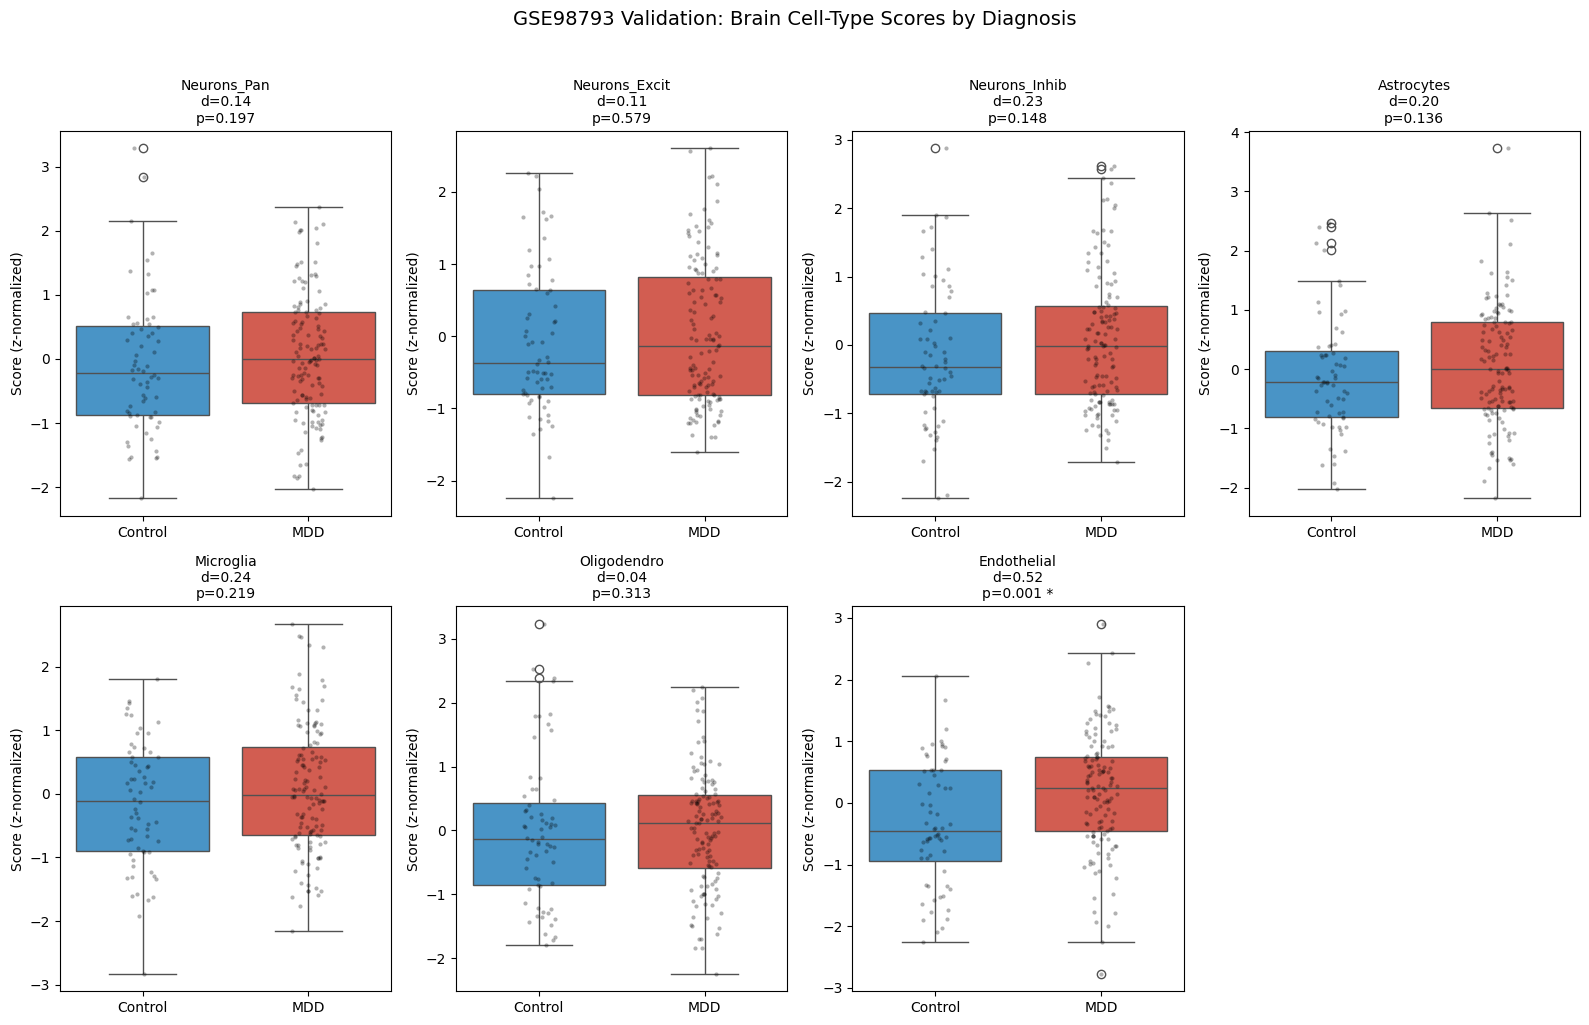

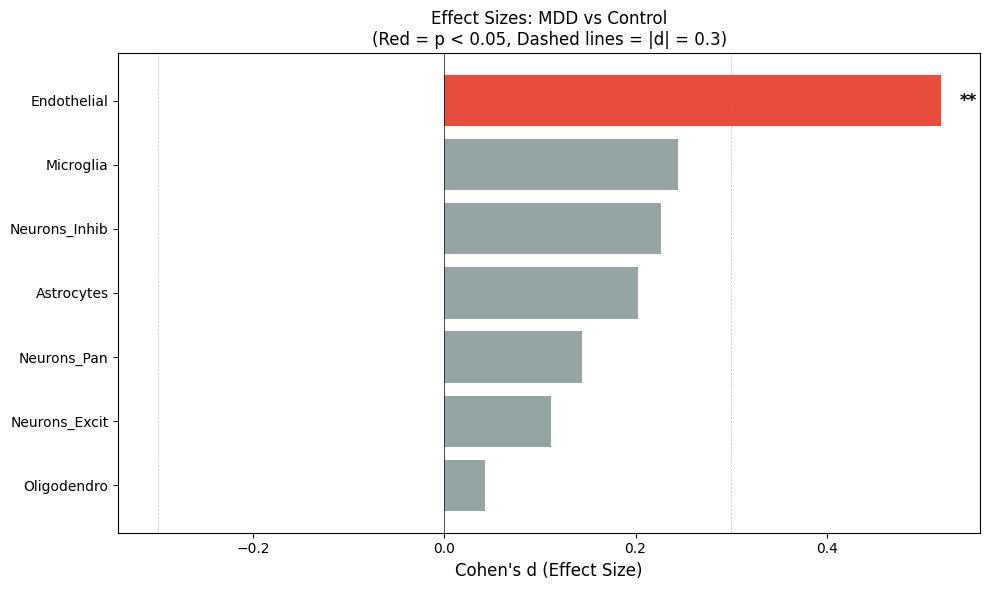


COMPARISON WITH ORIGINAL FINDINGS
  Neurons_Inhib       : Original d=-0.70 | GSE98793 d=+0.23, p=0.148 | ✗ Did not replicate
  Endothelial         : Original d=+0.70 | GSE98793 d=+0.52, p=0.001 | ✓ REPLICATED
  Oligodendro         : Original d=+0.60 | GSE98793 d=+0.04, p=0.313 | ~ Same direction (not sig)
  Microglia           : Original d=+0.40 | GSE98793 d=+0.24, p=0.219 | ~ Same direction (not sig)

VALIDATION COMPLETE

Key outputs saved to ./output/Phase_4/
  - GSE98793_deconvolution_results.csv
  - GSE98793_validation_stats.csv
  - GSE98793_replication_summary.csv
  - GSE98793_validation_boxplots.png
  - GSE98793_validation_effectsizes.png


In [47]:
# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    
    # Paths
    expr_path = f"{data_dir}/GSE98793_prepared_expression.csv"
    meta_path = f"{data_dir}/GSE98793_metadata.csv"
    
    # Check if data exists
    if not os.path.exists(expr_path):
        print("ERROR: Expression data not found. Run your download script first.")
        print(f"Expected: {expr_path}")
        exit(1)
    
    # Load data
    expr, meta = load_data(expr_path, meta_path)
    
    # Run deconvolution
    deconv_results = run_deconvolution(expr)
    
    # Save deconvolution results
    deconv_results.to_csv(f"{output_dir}/GSE98793_deconvolution_results.csv")
    print(f"\nSaved: {output_dir}/GSE98793_deconvolution_results.csv")
    
    # Statistical validation
    stats_results, merged_data = statistical_validation(deconv_results, meta)
    
    # Save stats
    stats_results.to_csv(f"{output_dir}/GSE98793_validation_stats.csv", index=False)
    print(f"Saved: {output_dir}/GSE98793_validation_stats.csv")
    
    # Plot results
    plot_validation_results(merged_data, stats_results, output_dir)
    
    # Compare with original
    replication_df = compare_with_original_findings(stats_results)
    replication_df.to_csv(f"{output_dir}/GSE98793_replication_summary.csv", index=False)
    
    print("\n" + "="*50)
    print("VALIDATION COMPLETE")
    print("="*50)
    print(f"\nKey outputs saved to {output_dir}/")
    print("  - GSE98793_deconvolution_results.csv")
    print("  - GSE98793_validation_stats.csv") 
    print("  - GSE98793_replication_summary.csv")
    print("  - GSE98793_validation_boxplots.png")
    print("  - GSE98793_validation_effectsizes.png")